In [6]:
# !pip -q install QuantLib tqdm

import sys, os
sys.path.append("../")
# + "/drive/MyDrive/Colab Notebooks/deep-hedging-master"
# from IPython.display import clear_output
print("   ", os.getcwd())
import numpy as np
import QuantLib as ql
import tensorflow as tf
from scipy.stats import norm

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.compat.v1.keras.optimizers import Adam
from tensorflow.keras.models import Model

import matplotlib.pyplot as plt

from stochastic_processes import BlackScholesProcess
from instruments import EuropeanCall
from loss_metrics import Entropy
from utilities import train_test_split

# tf.config.experimental_run_functions_eagerly(True)
# tf.config.set_soft_device_placement(True)
tf.config.experimental.list_physical_devices(device_type="GPU")
print("\nFinish installing and importing all necessary libraries!", tf.__version__)

from deep_hedging.deep_hedging_gru_0819 import Deep_Hedging_Model, Delta_SubModel


    e:\download\chrome_download\Calibrating-Rough-Volatility-Models-with-Deep-Learning-master

Finish installing and importing all necessary libraries! 2.4.0


In [7]:

# <font color='Blue'>**User Inputs**</font>
print("=====")
# Geometric Brownian Motion.
N = 30  # Number of time steps (in days)

S0 = 100  # Stock price at time = 0
sigma = 0.1224# Implied volatility
risk_free = 0.0  # Risk-free rate
dividend = 0.0  # Continuous dividend yield
print("=====")
Ktrain = 1 * (10 ** 5)  # Size of training sample.
Ktest_ratio = 0.2  # Fraction of training sample as testing sample.

# European call option (short).
strike = S0
payoff_func = lambda x: -np.maximum(x - strike, 0.0)
calculation_date = ql.Date.todaysDate()
maturity_date = ql.Date.todaysDate() + N

# Day convention.
day_count = ql.Actual365Fixed()  # Actual/Actual (ISDA)

# Proportional transaction cost.
epsilon = 0.0

# Information set (in string)
# Choose from: S, log_S, normalized_log_S (by S0)
information_set = "normalized_log_S"

# Loss function
# loss_type = "CVaR" (Expected Shortfall) -> loss_param = alpha
# loss_type = "Entropy" -> loss_param = lambda

loss_type = "Entropy"
loss_param = 1.0

# Neural network (NN) structure
m = 15  # Number of neurons in each hidden layer.
d = 1  # Number of hidden layers (Note including input nor output layer)

# Neural network training parameters
lr = 1e-2  # Learning rate
batch_size = 400  # Batch size
epochs = 30 # Number of epochs

# Other parameters
use_batch_norm = False
kernel_initializer = "he_uniform"

activation_dense = "leaky_relu"
activation_output = "sigmoid"
final_period_cost = False

delta_constraint = (0.0, 1.0)
share_stretegy_across_time = False
cost_structure = "proportional"

# Other control flags for development purpose.
mc_simulator = "QuantLib"  # "QuantLib" or "Numpy"

seed = 0  # Random seed. Change to have deterministic outcome.

print("---------")

# Total obs = Training + Testing
nobs = int(Ktrain * (1 + Ktest_ratio))

# Length of one time-step (as fraction of a year).
dt = day_count.yearFraction(calculation_date, calculation_date + 1)
maturity = N * dt  # Maturities (in the unit of a year)

# Total obs = Training + Testing
S = np.load('./data/deep_hedging/rb_price.npy')
list_true = []
for i in S[:,-1]:
    if i>70 and i<130:
        list_true.append(True)
    else:
        list_true.append(False)
aa = S[list_true]
S = aa[0:(aa.shape[0]//400)*400,:]
# S = 100*S
# S = S
stochastic_process = BlackScholesProcess(s0 = S0, sigma = sigma, risk_free = risk_free, \
                        dividend = dividend, day_count = day_count, seed=seed)

# S = stochastic_process.gen_path(maturity, N, nobs)
# <font color='Blue'>**Prepare data to be fed into the deep hedging algorithm.**</font>

payoff_T = payoff_func(S[:, -1])  # Payoff of the call option

trade_set = np.stack((S), axis=1)  # Trading set

if information_set is "S":
    I = np.stack((S), axis=1)  # Information set
elif information_set is "log_S":
    I = np.stack((np.log(S)), axis=1)
elif information_set is "normalized_log_S":
    I = np.stack((np.log(S / S0)), axis=1)

# Structure of xtrain:
#   1) Trade set: [S]
#   2) Information set: [S]
#   3) payoff (dim = 1)
x_all = []
for i in range(N + 1):
    x_all += [trade_set[i, :, None]]
    if i != N:
        x_all += [I[i, :, None]]
x_all += [payoff_T[:, None]]

# Split the entire sample into a training sample and a testing sample.
test_size = int(Ktrain * Ktest_ratio)
[xtrain, xtest] = train_test_split(x_all, test_size=test_size)  # 62*100000, 62*20000
[S_train, S_test] = train_test_split([S], test_size=test_size)  # 100000*31， 20000*31
[option_payoff_train, option_payoff_test] = train_test_split([x_all[-1]], test_size=test_size)  # 1*100000， 1*20000

print("Finish preparing data!")



optimizer = Adam(learning_rate=lr)

# Setup and compile the model
model_recurrent = Deep_Hedging_Model(N=N, d=d + 2, m=m, risk_free=risk_free, \
                                     dt=dt, strategy_type="recurrent", epsilon=epsilon, \
                                     use_batch_norm=use_batch_norm, kernel_initializer=kernel_initializer, \
                                     activation_dense=activation_dense, activation_output=activation_output, \
                                     final_period_cost=final_period_cost)

loss = Entropy(model_recurrent.output, None, loss_param)
model_recurrent.add_loss(loss)

model_recurrent.compile(optimizer=optimizer)

early_stopping = EarlyStopping(monitor="loss", \
                               patience=10, min_delta=1e-4, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor="loss", \
                              factor=0.5, patience=2, min_delta=1e-3, verbose=0)

callbacks = [early_stopping, reduce_lr]
dataset = []
print("============", len(xtrain))
# for i in range(len(xtrain)):
#     print("--i is ",i)
#     dataset = dataset + [tf.data.Dataset.from_tensor_slices(xtrain).batch(batch_size=batch_size)]
# dataset = tf.data.Dataset.from_tensor_slices(xtrain)
# dataset = dataset.batch(batch_size=batch_size)
# Fit the model.
model_recurrent.fit(x=xtrain, batch_size=batch_size, epochs=epochs, validation_data=xtest, verbose=1)  #
# model_recurrent.fit(x=dataset,  epochs=epochs,  verbose=1)  #

# clear_output()
print("Finished running deep hedging algorithm! (Simple Network)")

print("\n\ns0 = " + str(S0))
print("sigma = " + str(sigma))
print("risk_free = " + str(risk_free) + "\n")
print("Number of time steps = " + str(N))
print("Length of each time step = " + "1/365\n")
print("Simulation Done!")


=====
=====
---------
Finish preparing data!
lambda is  1.0
mean is  KerasTensor(type_spec=TensorSpec(shape=(), dtype=tf.float32, name=None), name='tf.math.reduce_mean/Mean:0', description="created by layer 'tf.math.reduce_mean'")
============ 62
Epoch 1/30
246/246 [==============================] - 27s 69ms/step - loss: 11.0795 - val_loss: 9.1844
Epoch 2/30
246/246 [==============================] - 16s 64ms/step - loss: 8.6707 - val_loss: 8.0539
Epoch 3/30
246/246 [==============================] - 17s 69ms/step - loss: 7.9828 - val_loss: 8.0900
Epoch 4/30
246/246 [==============================] - 15s 60ms/step - loss: 7.7539 - val_loss: 7.8634
Epoch 5/30
246/246 [==============================] - 15s 60ms/step - loss: 7.9935 - val_loss: 7.8086
Epoch 6/30
246/246 [==============================] - 15s 60ms/step - loss: 7.6298 - val_loss: 7.3176
Epoch 7/30
246/246 [==============================] - 15s 60ms/step - loss: 7.3874 - val_loss: 7.9765
Epoch 8/30
246/246 [==================

In [9]:
call = EuropeanCall()

price_BS = call.get_BS_price(S = S_test[0], sigma = sigma, \
              risk_free = risk_free, dividend = dividend, K = strike, \
              exercise_date = maturity_date, \
              calculation_date = calculation_date, \
              day_count = day_count, dt = dt)
delta_BS = call.get_BS_delta(S = S_test[0], sigma = sigma, \
              risk_free = risk_free, dividend = dividend, K = strike, \
              exercise_date = maturity_date, \
              calculation_date = calculation_date, 
              day_count = day_count, dt = dt)

PnL_BS =  call.get_BS_PnL(S= S_test[0], \
              payoff= payoff_func(S_test[0][:,-1]), delta=delta_BS, \
              dt= dt, risk_free = risk_free, \
              final_period_cost=final_period_cost, epsilon=epsilon, \
              cost_structure = cost_structure )

risk_neutral_price = \
    -option_payoff_test[0].mean()*np.exp(-risk_free*(N*dt))
risk_neutral_price

3.594217035345809

In [10]:

print("The Black-Scholes model price is %2.3f." % price_BS[0][0])
print("The Risk Neutral price is %2.3f." % risk_neutral_price)

nn_recurrent_price = model_recurrent.evaluate(xtest, batch_size=batch_size, verbose=0)
try:
  print("aaaa")
  nn_recurrent_price = model_recurrent.evaluate(xtest, batch_size=batch_size, verbose=0)
  print("The Deep Hedging (with recurrent network) price is %2.3f." % nn_recurrent_price)
except:
  print("No Recurrent model.")

The Black-Scholes model price is 1.400.
The Risk Neutral price is 3.594.
aaaa
The Deep Hedging (with recurrent network) price is 6.975.


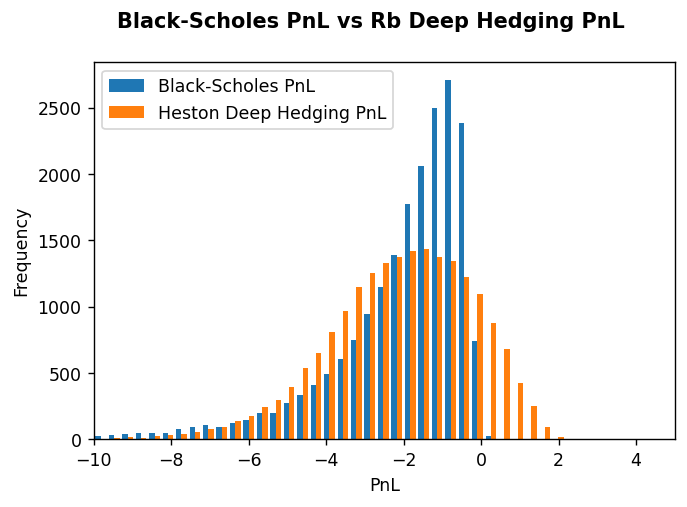

In [11]:
%matplotlib inline
bar1 = PnL_BS + price_BS[0][0]
bar2 = model_recurrent.predict(xtest,batch_size=batch_size).squeeze() + price_BS[0][0]

# Plot Black-Scholes PnL and Deep Hedging PnL (with BS_price charged on both).
fig_PnL = plt.figure(dpi= 125, facecolor='w')
fig_PnL.suptitle("Black-Scholes PnL vs Rb Deep Hedging PnL \n", \
      fontweight="bold")
ax = fig_PnL.add_subplot()
# ax.set_title("Simple Network Structure with epsilon = " + str(epsilon), \
#       fontsize=8)
ax.set_xlabel("PnL")
ax.set_ylabel("Frequency")
# ax.set_xbound(lower=-0.5,upper=0.5)
ax.set_xlim(-10,5)
ax.hist((bar1,bar2), bins=120, \
          label=["Black-Scholes PnL","Heston Deep Hedging PnL"])
ax.legend()
plt.show()

In [15]:
len(bar2)

20000

In [6]:
bar1_rb_ftse = np.loadtxt('bar1_heston_spx.npz')
bar2_rb_ftse = np.loadtxt('bar2_heston_spx.npz')


# Plot Black-Scholes PnL and Deep Hedging PnL (with BS_price charged on both).
fig_PnL = plt.figure(dpi= 125, facecolor='w')
fig_PnL.suptitle("Heston deep hedging P&L vs rBergomi deep hedging P&L \n", \
      fontweight="bold")
ax = fig_PnL.add_subplot()
# ax.set_title("Simple Network Structure with epsilon = " + str(epsilon), \
#       fontsize=8)
ax.set_xlabel("P&L")
ax.set_ylabel("Frequency")
ax.set_xbound(lower=-0.5,upper=0.5)
# ax.set_xlim(-2,1.5)
ax.hist((bar1_rb_ftse+0.6,bar2_rb_ftse+0.6,bar2), bins=90, \
          label=["Black-Scholes P&L","Heston deep hedging P&L","RBergomi deep hedging P&L"],
          color=['#C03302','#B88572','#3A001E'])
ax.legend()
plt.show()

OSError: bar1_heston_spx.npz not found.

In [15]:
aa = bar2
print("rBergomi-ftse-mean",np.mean(aa))
print("rBergomi-ftse-std",np.std(aa))

rBergomi-ftse-mean 0.11711863
rBergomi-ftse-std 0.67883164


In [21]:
bar2_rb_ftse=bar2_rb_ftse+0.6
bar1_rb_ftse=bar1_rb_ftse+0.6

In [22]:
print("BS-ftse-mean",np.mean(bar1_rb_ftse))
print("BS-ftse-std",np.std(bar1_rb_ftse))

BS-ftse-mean -0.1113365469115151
BS-ftse-std 0.8394009498895068


In [23]:
print("heston-ftse-mean",np.mean(bar2_rb_ftse))
print("heston-ftse-std",np.std(bar2_rb_ftse))

heston-ftse-mean -0.11663801299929619
heston-ftse-std 0.7478942890590821


In [24]:
import pandas as pd
def var_historic(r, level=1):
    """
    Takes in a series of returns (r), and the percentage level
(level)
    Returns the historic Value at Risk at a specified level
    i.e. returns the number such that "level" percent of the returns
    fall below that number, and the (100-level) percent are above
    """
    if isinstance(r, pd.DataFrame):
        return r.aggregate(var_historic, level=level)
    elif isinstance(r, pd.Series):
        return -np.percentile(r, level)
    else:
        raise TypeError("Expected r to be a Series or DataFrame")
varheston99=var_historic(pd.Series(bar2_rb_ftse), level=0.99)
varheston90=var_historic(pd.Series(bar2_rb_ftse), level=0.90)
varheston60=var_historic(pd.Series(bar2_rb_ftse), level=0.60)
print("varheston99:",varheston99)
print("varheston90:",varheston90)
print("varheston60:",varheston60)

varheston99: 2.016784362578392
varheston90: 2.0654804372787474
varheston60: 2.2445865788459773


In [25]:
import pandas as pd
def var_historic(r, level=1):
    """
    Takes in a series of returns (r), and the percentage level
(level)
    Returns the historic Value at Risk at a specified level
    i.e. returns the number such that "level" percent of the returns
    fall below that number, and the (100-level) percent are above
    """
    if isinstance(r, pd.DataFrame):
        return r.aggregate(var_historic, level=level)
    elif isinstance(r, pd.Series):
        return -np.percentile(r, level)
    else:
        raise TypeError("Expected r to be a Series or DataFrame")
varheston99=var_historic(pd.Series(aa), level=0.99)
varheston90=var_historic(pd.Series(aa), level=0.90)
varheston60=var_historic(pd.Series(aa), level=0.60)
print("varrB99:",varheston99)
print("varrB90:",varheston90)
print("varrB60:",varheston60)

varrB99: 1.9864479400396349
varrB90: 2.052747687339783
varrB60: 2.2620439500808716


In [27]:
import pandas as pd
def var_historic(r, level=1):
    """
    Takes in a series of returns (r), and the percentage level
(level)
    Returns the historic Value at Risk at a specified level
    i.e. returns the number such that "level" percent of the returns
    fall below that number, and the (100-level) percent are above
    """
    if isinstance(r, pd.DataFrame):
        return r.aggregate(var_historic, level=level)
    elif isinstance(r, pd.Series):
        return -np.percentile(r, level)
    else:
        raise TypeError("Expected r to be a Series or DataFrame")
varheston99=var_historic(pd.Series(bar1_rb_ftse), level=0.99)
varheston90=var_historic(pd.Series(bar1_rb_ftse), level=0.90)
varheston60=var_historic(pd.Series(bar1_rb_ftse), level=0.60)
print("varBS99:",varheston99)
print("varBS90:",varheston90)
print("varBS60:",varheston60)

varBS99: 3.1900645759025505
varBS90: 3.2686598235266073
varBS60: 3.582694446829539


In [32]:
np.percentile(bar2,[5,95])

array([-1.06660774,  1.00954795])

In [35]:
np.mean(bar2[(bar2 > -1.06660774) & (bar2 <= 1.00954795)])

0.15764152